# COSMOS master catalogue

This notebook presents the merge of the various pristine catalogues to produce HELP mater catalogue on COSMOS.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]
This notebook was executed on: 
2018-03-13 19:00:01.882259


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
#COSMOS was originally run with the official LAigle et al 2015 catalogue 
#so all those ids and photometry values must be preserved
cosmos2015 = Table.read("{}/COSMOS2015_HELP.fits".format(TMP_DIR))

In [5]:
candels = Table.read("{}/CANDELS.fits".format(TMP_DIR))
cfhtls = Table.read("{}/CFHTLS.fits".format(TMP_DIR))
decals = Table.read("{}/DECaLS.fits".format(TMP_DIR))
hsc_deep = Table.read("{}/HSC-DEEP.fits".format(TMP_DIR))
hsc_udeep = Table.read("{}/HSC-UDEEP.fits".format(TMP_DIR))
kids = Table.read("{}/KIDS.fits".format(TMP_DIR))
ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))
las = Table.read("{}/UKIDSS-LAS.fits".format(TMP_DIR))
wirds = Table.read("{}/CFHT-WIRDS.fits".format(TMP_DIR))



## II - Merging tables

We first merge the optical catalogues and then add the infrared ones: CANDELS, CFHTLS, DECaLS, HSC, KIDS, PanSTARRS, UKIDSS-LAS, and CFHT-WIRDS.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### COSMOS 2015

In [6]:
master_catalogue = cosmos2015
master_catalogue['cosmos_ra'].name = 'ra'
master_catalogue['cosmos_dec'].name = 'dec'

### Add CANDELS

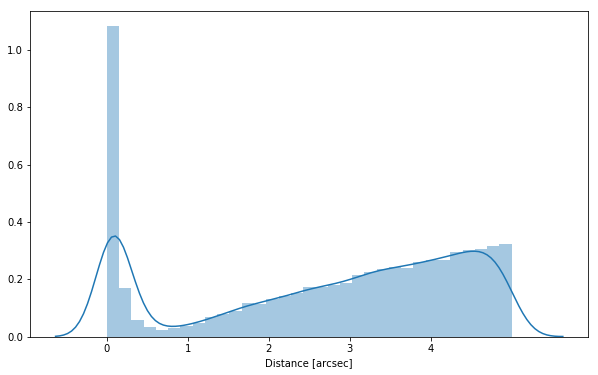

In [7]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(candels['candels_ra'], candels['candels_dec'])
)

In [8]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, candels, "candels_ra", "candels_dec", radius=0.8*u.arcsec)

### Add CFHTLS

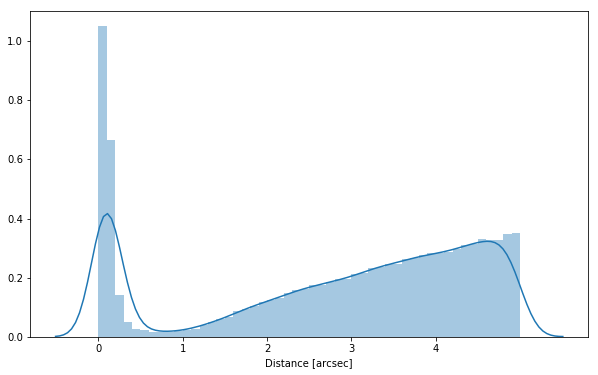

In [9]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(cfhtls['cfhtls_ra'], cfhtls['cfhtls_dec'])
)

In [10]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, cfhtls, "cfhtls_ra", "cfhtls_dec", radius=0.8*u.arcsec)

### Add DECaLS

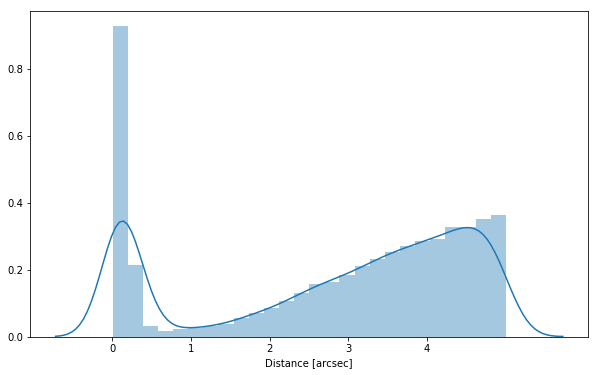

In [11]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(decals['decals_ra'], decals['decals_dec'])
)

In [12]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, decals, "decals_ra", "decals_dec", radius=0.8*u.arcsec)

### Add HSC-UDEEP

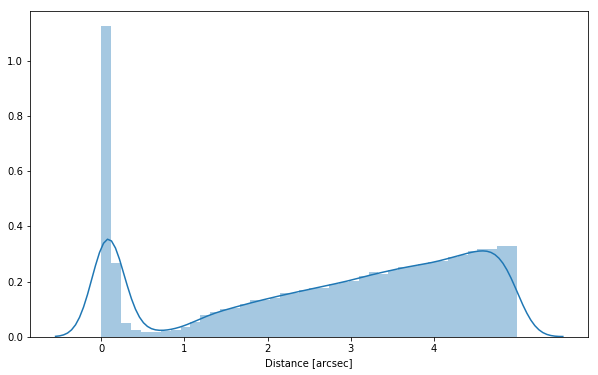

In [13]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(hsc_udeep['hsc-udeep_ra'], hsc_udeep['hsc-udeep_dec'])
)

In [14]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, hsc_udeep, "hsc-udeep_ra", "hsc-udeep_dec", radius=0.8*u.arcsec)

### Add HSC-DEEP

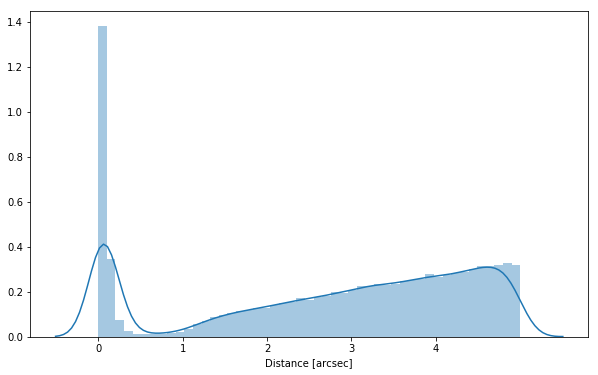

In [15]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(hsc_deep['hsc-deep_ra'], hsc_deep['hsc-deep_dec'])
)

In [16]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, hsc_deep, "hsc-deep_ra", "hsc-deep_dec", radius=0.8*u.arcsec)

### Add KIDS

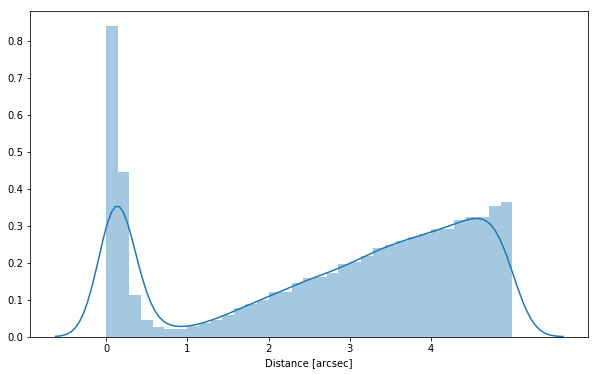

In [17]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(kids['kids_ra'], kids['kids_dec'])
)

In [18]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, kids, "kids_ra", "kids_dec", radius=0.8*u.arcsec)

### Add UKIDSS LAS

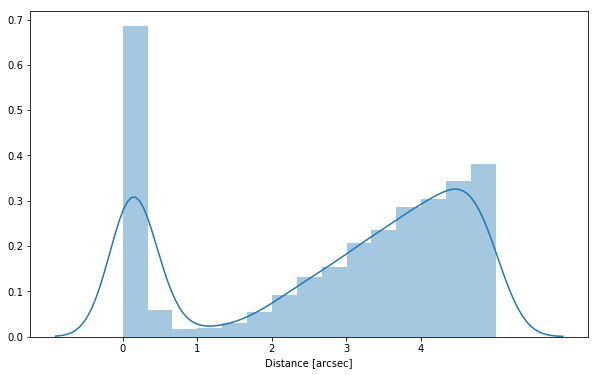

In [19]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(las['las_ra'], las['las_dec'])
)

In [20]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, las, "las_ra", "las_dec", radius=0.8*u.arcsec)

### Add CFHT-WIRDS

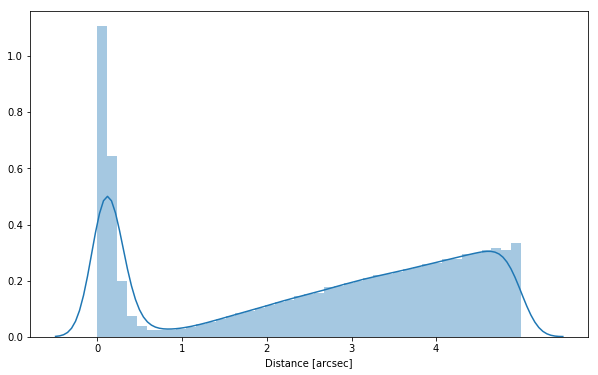

In [21]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(wirds['wirds_ra'], wirds['wirds_dec'])
)

In [22]:
#Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, wirds, "wirds_ra", "wirds_dec", radius=1.*u.arcsec)

## Add PanSTARRS

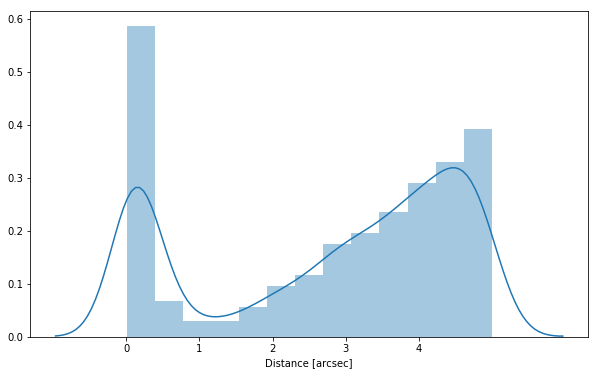

In [23]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(ps1['ps1_ra'], ps1['ps1_dec'])
)

In [24]:
#Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, ps1, "ps1_ra", "ps1_dec", radius=1.*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [25]:
for col in master_catalogue.colnames:
    #print(col)
    if (col.startswith("m_") 
        or col.startswith("merr_") 
        or col.startswith("f_") 
        or col.startswith("ferr_") 
        or "stellarity" in col):
        master_catalogue[col] = master_catalogue[col].astype(float)
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [26]:
master_catalogue[:10].show_in_notebook()

idx,help_id,cosmos_id,ra,dec,cosmos_stellarity,m_cosmos-vista_ks,merr_cosmos-vista_ks,f_ap_cosmos-vista_ks,ferr_ap_cosmos-vista_ks,m_cosmos-vista_y,merr_cosmos-vista_y,f_ap_cosmos-vista_y,ferr_ap_cosmos-vista_y,m_cosmos-vista_h,merr_cosmos-vista_h,f_ap_cosmos-vista_h,ferr_ap_cosmos-vista_h,m_cosmos-vista_j,merr_cosmos-vista_j,f_ap_cosmos-vista_j,ferr_ap_cosmos-vista_j,m_cosmos-megacam_u,merr_cosmos-megacam_u,f_ap_cosmos-megacam_u,ferr_ap_cosmos-megacam_u,m_cosmos-suprime_b,merr_cosmos-suprime_b,f_ap_cosmos-suprime_b,ferr_ap_cosmos-suprime_b,m_cosmos-suprime_v,merr_cosmos-suprime_v,f_ap_cosmos-suprime_v,ferr_ap_cosmos-suprime_v,m_cosmos-suprime_ip,merr_cosmos-suprime_ip,f_ap_cosmos-suprime_ip,ferr_ap_cosmos-suprime_ip,m_cosmos-suprime_rc,merr_cosmos-suprime_rc,f_ap_cosmos-suprime_rc,ferr_ap_cosmos-suprime_rc,m_cosmos-suprime_zp,merr_cosmos-suprime_zp,f_ap_cosmos-suprime_zp,ferr_ap_cosmos-suprime_zp,m_cosmos-suprime_zpp,merr_cosmos-suprime_zpp,f_ap_cosmos-suprime_zpp,ferr_ap_cosmos-suprime_zpp,m_cosmos-suprime_ia484,merr_cosmos-suprime_ia484,f_ap_cosmos-suprime_ia484,ferr_ap_cosmos-suprime_ia484,m_cosmos-suprime_ia527,merr_cosmos-suprime_ia527,f_ap_cosmos-suprime_ia527,ferr_ap_cosmos-suprime_ia527,m_cosmos-suprime_ia624,merr_cosmos-suprime_ia624,f_ap_cosmos-suprime_ia624,ferr_ap_cosmos-suprime_ia624,m_cosmos-suprime_ia679,merr_cosmos-suprime_ia679,f_ap_cosmos-suprime_ia679,ferr_ap_cosmos-suprime_ia679,m_cosmos-suprime_ia738,merr_cosmos-suprime_ia738,f_ap_cosmos-suprime_ia738,ferr_ap_cosmos-suprime_ia738,m_cosmos-suprime_ia767,merr_cosmos-suprime_ia767,f_ap_cosmos-suprime_ia767,ferr_ap_cosmos-suprime_ia767,m_cosmos-suprime_ib427,merr_cosmos-suprime_ib427,f_ap_cosmos-suprime_ib427,ferr_ap_cosmos-suprime_ib427,m_cosmos-suprime_ib464,merr_cosmos-suprime_ib464,f_ap_cosmos-suprime_ib464,ferr_ap_cosmos-suprime_ib464,m_cosmos-suprime_ib505,merr_cosmos-suprime_ib505,f_ap_cosmos-suprime_ib505,ferr_ap_cosmos-suprime_ib505,m_cosmos-suprime_ib574,merr_cosmos-suprime_ib574,f_ap_cosmos-suprime_ib574,ferr_ap_cosmos-suprime_ib574,m_cosmos-suprime_ib709,merr_cosmos-suprime_ib709,f_ap_cosmos-suprime_ib709,ferr_ap_cosmos-suprime_ib709,m_cosmos-suprime_ib827,merr_cosmos-suprime_ib827,f_ap_cosmos-suprime_ib827,ferr_ap_cosmos-suprime_ib827,m_cosmos-suprime_nb711,merr_cosmos-suprime_nb711,f_ap_cosmos-suprime_nb711,ferr_ap_cosmos-suprime_nb711,m_cosmos-suprime_nb816,merr_cosmos-suprime_nb816,f_ap_cosmos-suprime_nb816,ferr_ap_cosmos-suprime_nb816,m_cosmos-wircam_h,merr_cosmos-wircam_h,f_ap_cosmos-wircam_h,ferr_ap_cosmos-wircam_h,m_cosmos-wircam_ks,merr_cosmos-wircam_ks,f_ap_cosmos-wircam_ks,ferr_ap_cosmos-wircam_ks,m_cosmos-suprime_y,merr_cosmos-suprime_y,f_ap_cosmos-suprime_y,ferr_ap_cosmos-suprime_y,f_cosmos-irac_i1,ferr_cosmos-irac_i1,m_cosmos-irac_i1,merr_cosmos-irac_i1,f_cosmos-irac_i2,ferr_cosmos-irac_i2,m_cosmos-irac_i2,merr_cosmos-irac_i2,f_cosmos-irac_i3,ferr_cosmos-irac_i3,m_cosmos-irac_i3,merr_cosmos-irac_i3,f_cosmos-irac_i4,ferr_cosmos-irac_i4,m_cosmos-irac_i4,merr_cosmos-irac_i4,f_cosmos-vista_ks,ferr_cosmos-vista_ks,flag_cosmos-vista_ks,m_ap_cosmos-vista_ks,merr_ap_cosmos-vista_ks,f_cosmos-vista_y,ferr_cosmos-vista_y,flag_cosmos-vista_y,m_ap_cosmos-vista_y,merr_ap_cosmos-vista_y,f_cosmos-vista_h,ferr_cosmos-vista_h,flag_cosmos-vista_h,m_ap_cosmos-vista_h,merr_ap_cosmos-vista_h,f_cosmos-vista_j,ferr_cosmos-vista_j,flag_cosmos-vista_j,m_ap_cosmos-vista_j,merr_ap_cosmos-vista_j,f_cosmos-megacam_u,ferr_cosmos-megacam_u,flag_cosmos-megacam_u,m_ap_cosmos-megacam_u,merr_ap_cosmos-megacam_u,f_cosmos-suprime_b,ferr_cosmos-suprime_b,flag_cosmos-suprime_b,m_ap_cosmos-suprime_b,merr_ap_cosmos-suprime_b,f_cosmos-suprime_v,ferr_cosmos-suprime_v,flag_cosmos-suprime_v,m_ap_cosmos-suprime_v,merr_ap_cosmos-suprime_v,f_cosmos-suprime_ip,ferr_cosmos-suprime_ip,flag_cosmos-suprime_ip,m_ap_cosmos-suprime_ip,merr_ap_cosmos-suprime_ip,f_cosmos-suprime_rc,ferr_cosmos-suprime_rc,flag_cosmos-suprime_rc,m_ap_cosmos-suprime_rc,merr_ap_cosmos-suprime_rc,f_cosmos-suprime

## III - Merging flags and stellarity

Each pristine catalogue contains a flag indicating if the source was associated to a another nearby source that was removed during the cleaning process.  We merge these flags in a single one.

In [27]:
flag_cleaned_columns = [column for column in master_catalogue.colnames
                        if 'flag_cleaned' in column]

flag_column = np.zeros(len(master_catalogue), dtype=bool)
for column in flag_cleaned_columns:
    flag_column |= master_catalogue[column]
    
master_catalogue.add_column(Column(data=flag_column, name="flag_cleaned"))
master_catalogue.remove_columns(flag_cleaned_columns)

Wirds was created with a merge so contains a flag to be merged with the merg flag produced here

In [28]:
# master_catalogue['flag_merged'] |= master_catalogue['wirds_flag_merged']
# master_catalogue.remove_columns('wirds_flag_merged')

Each pristine catalogue contains a flag indicating the probability of a source being a Gaia object (0: not a Gaia object, 1: possibly, 2: probably, 3: definitely).  We merge these flags taking the highest value.

In [29]:
flag_gaia_columns = [column for column in master_catalogue.colnames
                     if 'flag_gaia' in column]

master_catalogue.add_column(Column(
    data=np.max([master_catalogue[column] for column in flag_gaia_columns], axis=0),
    name="flag_gaia"
))
master_catalogue.remove_columns(flag_gaia_columns)

Each prisitine catalogue may contain one or several stellarity columns indicating the probability (0 to 1) of each source being a star.  We merge these columns taking the highest value.

In [30]:
stellarity_columns = [column for column in master_catalogue.colnames
                      if 'stellarity' in column]

print(", ".join(stellarity_columns))

cosmos_stellarity, candels_stellarity, cfhtls_stellarity, decals_stellarity, hsc-udeep_stellarity, hsc-deep_stellarity, kids_stellarity, las_stellarity


In [31]:

# We create an masked array with all the stellarities and get the maximum value, as well as its
# origin.  Some sources may not have an associated stellarity.
stellarity_array = np.array([master_catalogue[column] for column in stellarity_columns])
stellarity_array = np.ma.masked_array(stellarity_array, np.isnan(stellarity_array))

max_stellarity = np.max(stellarity_array, axis=0)
max_stellarity.fill_value = np.nan

no_stellarity_mask = max_stellarity.mask

master_catalogue.add_column(Column(data=max_stellarity.filled(), name="stellarity"))

stellarity_origin = np.full(len(master_catalogue), "NO_INFORMATION", dtype="S20")
stellarity_origin[~no_stellarity_mask] = np.array(stellarity_columns)[np.argmax(stellarity_array, axis=0)[~no_stellarity_mask]]

master_catalogue.add_column(Column(data=stellarity_origin, name="stellarity_origin"))

master_catalogue.remove_columns(stellarity_columns)

## IV - Adding E(B-V) column

In [32]:
master_catalogue.add_column(
    ebv(master_catalogue['ra'], master_catalogue['dec'])
)

## V a - Adding HELP unique identifiers and field columns

In [33]:
#master_catalogue.add_column(Column(gen_help_id(master_catalogue['ra'], master_catalogue['dec']),
#                                   name="help_id"))
#Use HELP ids from original cat to make sure they are identical

master_catalogue['help_id'] = master_catalogue['help_id'].astype('S27')
master_catalogue.add_column(Column(gen_help_id(master_catalogue['ra'], master_catalogue['dec']),
                                   name="help_id_temp"))
mask = (master_catalogue['help_id'] == '-1') | (master_catalogue['help_id'] == '')
master_catalogue['help_id'][mask] = master_catalogue['help_id_temp'][mask]
master_catalogue.remove_column('help_id_temp')

master_catalogue.add_column(Column(np.full(len(master_catalogue), "COSMOS", dtype='<U18'),
                                   name="field"))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:7: StringTruncateWarning: truncated right side string(s) longer than 25 character(s) during assignment


In [34]:
# Check that the HELP Ids are unique
if len(master_catalogue) != len(np.unique(master_catalogue['help_id'])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

OK!


## V b - Adding spec-z

In [35]:
specz =  Table.read("../../dmu23/dmu23_COSMOS/data/COSMOS-specz-v2.5-public_helpcoverage_helpid_20160512.fits")

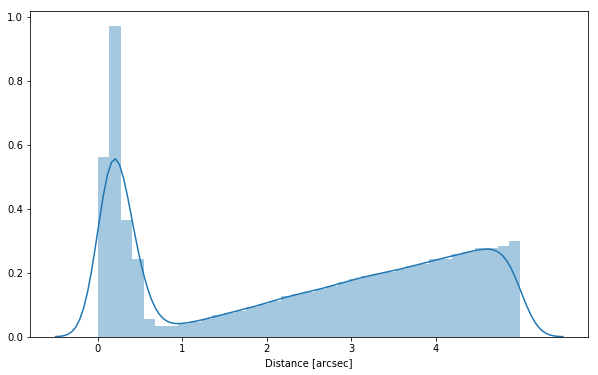

In [36]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(specz['ra'] * u.deg, specz['dec'] * u.deg)
)

In [37]:
master_catalogue = specz_merge(master_catalogue, specz, radius=1. * u.arcsec)

## VI - Choosing between multiple values for the same filter

### VI.a HSC-DEEP and HSC-UDEEP and COSMOS

On COSMOS2015 we have early HSC y band photometry. To ensure values are the same as for the original run, we take fluxes in this order: COSMOS, HSC-DEEP, HSC-UDEEP.

In [38]:
suprime_origin = Table()
suprime_origin.add_column(master_catalogue['help_id'])

In [39]:
suprime_stats = Table()
suprime_stats.add_column(Column(data=['g','r','i','z','y', 'n921'], name="Band"))
for col in ["HSC-UDEEP",  "HSC-DEEP", "COSMOS2015"]:
    suprime_stats.add_column(Column(data=np.full(6, 0), name="{}".format(col)))
    suprime_stats.add_column(Column(data=np.full(6, 0), name="use {}".format(col)))
    suprime_stats.add_column(Column(data=np.full(6, 0), name="{} ap".format(col)))
    suprime_stats.add_column(Column(data=np.full(6, 0), name="use {} ap".format(col)))
    

In [40]:
suprime_bands = ['g','r','i','z','y', 'n921'] 
for band in suprime_bands:

    # Suprime total flux 
    has_hsc_udeep = ~np.isnan(master_catalogue['f_hsc-udeep_' + band])
    has_hsc_deep  = ~np.isnan(master_catalogue['f_hsc-deep_' + band])
    if band == 'y':
        has_cosmos = ~np.isnan(master_catalogue['f_cosmos-suprime_y'])
    elif band != 'y':
        has_cosmos = np.full(len(master_catalogue), False, dtype=bool)
    
    use_cosmos = has_cosmos
    use_hsc_udeep = has_hsc_udeep & ~has_cosmos
    use_hsc_deep = has_hsc_deep & ~has_hsc_udeep & ~has_cosmos
    
 
    f_suprime = np.full(len(master_catalogue), np.nan)
    if band == 'y':
        f_suprime[use_cosmos] = master_catalogue['f_cosmos-suprime_y'][use_cosmos]
    f_suprime[use_hsc_udeep] = master_catalogue['f_hsc-udeep_' + band][use_hsc_udeep]
    f_suprime[use_hsc_deep] = master_catalogue['f_hsc-deep_' + band][use_hsc_deep]
 

    ferr_suprime = np.full(len(master_catalogue), np.nan)
    if band == 'y':
        ferr_suprime[use_cosmos] = master_catalogue['ferr_cosmos-suprime_y'][use_cosmos]
    ferr_suprime[use_hsc_udeep] = master_catalogue['ferr_hsc-udeep_' + band][use_hsc_udeep]
    ferr_suprime[use_hsc_deep] = master_catalogue['ferr_hsc-deep_' + band][use_hsc_deep]

    
    m_suprime = np.full(len(master_catalogue), np.nan)
    if band == 'y':
        m_suprime[use_cosmos] = master_catalogue['m_cosmos-suprime_y'][use_cosmos]
    m_suprime[use_hsc_udeep] = master_catalogue['m_hsc-udeep_' + band][use_hsc_udeep]
    m_suprime[use_hsc_deep] = master_catalogue['m_hsc-deep_' + band][use_hsc_deep]


    merr_suprime = np.full(len(master_catalogue), np.nan)
    if band == 'y':
        merr_suprime[use_cosmos] = master_catalogue['merr_cosmos-suprime_y'][use_cosmos]
    merr_suprime[use_hsc_udeep] = master_catalogue['merr_hsc-udeep_' + band][use_hsc_udeep]
    merr_suprime[use_hsc_deep] = master_catalogue['merr_hsc-deep_' + band][use_hsc_deep]


    flag_suprime = np.full(len(master_catalogue), False, dtype=bool)
    if band == 'y':
        flag_suprime[use_cosmos] = master_catalogue['flag_cosmos-suprime_y'][use_cosmos]
    flag_suprime[use_hsc_udeep] = master_catalogue['flag_hsc-udeep_' + band][use_hsc_udeep]
    flag_suprime[use_hsc_deep] = master_catalogue['flag_hsc-deep_' + band][use_hsc_deep]


    master_catalogue.add_column(Column(data=f_suprime, name="f_suprime_" + band))
    master_catalogue.add_column(Column(data=ferr_suprime, name="ferr_suprime_" + band))
    master_catalogue.add_column(Column(data=m_suprime, name="m_suprime_" + band))
    master_catalogue.add_column(Column(data=merr_suprime, name="merr_suprime_" + band))
    master_catalogue.add_column(Column(data=flag_suprime, name="flag_suprime_" + band))

    old_hsc_udeep_columns = ['f_hsc-udeep_' + band,
                               'ferr_hsc-udeep_' + band,
                               'm_hsc-udeep_' + band, 
                               'merr_hsc-udeep_' + band,
                               'flag_hsc-udeep_' + band]
    old_hsc_deep_columns = ['f_hsc-deep_' + band,
                               'ferr_hsc-deep_' + band,
                               'm_hsc-deep_' + band, 
                               'merr_hsc-deep_' + band,
                               'flag_hsc-deep_' + band]
    old_cosmos_columns = ['f_cosmos-suprime_' + band,
                               'ferr_cosmos-suprime_' + band,
                               'm_cosmos-suprime_' + band, 
                               'merr_cosmos-suprime_' + band,
                               'flag_cosmos-suprime_' + band]
    
    old_columns = old_hsc_udeep_columns + old_hsc_deep_columns
    if band == 'y':
        old_columns += old_cosmos_columns
    master_catalogue.remove_columns(old_columns)

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_hsc_udeep] = "HSC-UDEEP"
    origin[use_hsc_deep] = "HSC-DEEP"
    origin[use_cosmos] = "COSMOS2015"
 
    
    suprime_origin.add_column(Column(data=origin, name= 'f_suprime_' + band ))
    
  
    # Suprime aperture flux 
    has_ap_hsc_udeep = ~np.isnan(master_catalogue['f_ap_hsc-udeep_' + band])
    has_ap_hsc_deep  = ~np.isnan(master_catalogue['f_ap_hsc-deep_' + band])
    if band == 'y':
        has_ap_cosmos = ~np.isnan(master_catalogue['f_ap_cosmos-suprime_y'])
    elif band != 'y':
        has_ap_cosmos = np.full(len(master_catalogue), False, dtype=bool)
 
    
    use_ap_cosmos = has_ap_cosmos
    use_ap_hsc_udeep = has_ap_hsc_udeep & ~has_cosmos
    use_ap_hsc_deep = has_ap_hsc_deep & ~has_ap_hsc_udeep & ~has_cosmos
  

    f_ap_suprime = np.full(len(master_catalogue), np.nan)
    if band == 'y':
        f_ap_suprime[use_ap_cosmos] = master_catalogue['f_ap_cosmos-suprime_y'][use_ap_cosmos]
    f_ap_suprime[use_ap_hsc_udeep] = master_catalogue['f_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    f_ap_suprime[use_ap_hsc_deep] = master_catalogue['f_ap_hsc-deep_' + band][use_ap_hsc_deep]


    ferr_ap_suprime = np.full(len(master_catalogue), np.nan)
    if band == 'y':
        ferr_ap_suprime[use_ap_cosmos] = master_catalogue['ferr_ap_cosmos-suprime_y'][use_ap_cosmos]
    ferr_ap_suprime[use_ap_hsc_udeep] = master_catalogue['ferr_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    ferr_ap_suprime[use_ap_hsc_deep] = master_catalogue['ferr_ap_hsc-deep_' + band][use_ap_hsc_deep]
   
    
    m_ap_suprime = np.full(len(master_catalogue), np.nan)
    if band == 'y':
        m_ap_suprime[use_ap_cosmos] = master_catalogue['m_ap_cosmos-suprime_y'][use_ap_cosmos]
    m_ap_suprime[use_ap_hsc_udeep] = master_catalogue['m_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    m_ap_suprime[use_ap_hsc_deep] = master_catalogue['m_ap_hsc-deep_' + band][use_ap_hsc_deep]
  

    merr_ap_suprime = np.full(len(master_catalogue), np.nan)
    if band == 'y':
        merr_ap_suprime[use_ap_cosmos] = master_catalogue['merr_ap_cosmos-suprime_y'][use_ap_cosmos]
    merr_ap_suprime[use_ap_hsc_udeep] = master_catalogue['merr_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    merr_ap_suprime[use_ap_hsc_deep] = master_catalogue['merr_ap_hsc-deep_' + band][use_ap_hsc_deep]
  


    master_catalogue.add_column(Column(data=f_ap_suprime, name="f_ap_suprime_" + band))
    master_catalogue.add_column(Column(data=ferr_ap_suprime, name="ferr_ap_suprime_" + band))
    master_catalogue.add_column(Column(data=m_ap_suprime, name="m_ap_suprime_" + band))
    master_catalogue.add_column(Column(data=merr_ap_suprime, name="merr_ap_suprime_" + band))


    old_ap_hsc_udeep_columns = ['f_ap_hsc-udeep_' + band,
                               'ferr_ap_hsc-udeep_' + band,
                               'm_ap_hsc-udeep_' + band, 
                               'merr_ap_hsc-udeep_' + band]
    old_ap_hsc_deep_columns = ['f_ap_hsc-deep_' + band,
                               'ferr_ap_hsc-deep_' + band,
                               'm_ap_hsc-deep_' + band, 
                               'merr_ap_hsc-deep_' + band]
    old_ap_cosmos_columns = ['f_ap_cosmos-suprime_' + band,
                               'ferr_ap_cosmos-suprime_' + band,
                               'm_ap_cosmos-suprime_' + band, 
                               'merr_ap_cosmos-suprime_' + band]

    
    old_ap_columns = old_ap_hsc_udeep_columns + old_ap_hsc_deep_columns 
    if band == 'y':
        old_ap_columns += old_ap_cosmos_columns
    master_catalogue.remove_columns(old_ap_columns)

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_hsc_udeep] = "HSC-UDEEP"
    origin_ap[use_ap_hsc_deep] = "HSC-DEEP"
    origin_ap[use_ap_cosmos] = "COSMOS2015"

    
    suprime_origin.add_column(Column(data=origin_ap, name= 'f_ap_suprime_' + band ))

   
    suprime_stats['HSC-UDEEP'][suprime_stats['Band'] == band] = np.sum(has_hsc_udeep)
    suprime_stats['HSC-DEEP'][suprime_stats['Band'] == band] = np.sum(has_hsc_deep)
    suprime_stats['COSMOS2015'][suprime_stats['Band'] == band] = np.sum(has_cosmos)

    suprime_stats['use HSC-UDEEP'][suprime_stats['Band'] == band] = np.sum(use_hsc_udeep)
    suprime_stats['use HSC-DEEP'][suprime_stats['Band'] == band] = np.sum(use_hsc_deep)
    suprime_stats['use COSMOS2015'][suprime_stats['Band'] == band] = np.sum(use_cosmos)

    suprime_stats['HSC-UDEEP ap'][suprime_stats['Band'] == band] = np.sum(has_ap_hsc_udeep)
    suprime_stats['HSC-DEEP ap'][suprime_stats['Band'] == band] = np.sum(has_ap_hsc_deep)
    suprime_stats['COSMOS2015 ap'][suprime_stats['Band'] == band] = np.sum(has_ap_cosmos)
    
    suprime_stats['use HSC-UDEEP ap'][suprime_stats['Band'] == band] = np.sum(use_ap_hsc_udeep)
    suprime_stats['use HSC-DEEP ap'][suprime_stats['Band'] == band] = np.sum(use_ap_hsc_deep)
    suprime_stats['use COSMOS2015 ap'][suprime_stats['Band'] == band] = np.sum(use_ap_cosmos)

In [41]:
suprime_stats.show_in_notebook()

idx,Band,HSC-UDEEP,use HSC-UDEEP,HSC-UDEEP ap,use HSC-UDEEP ap,HSC-DEEP,use HSC-DEEP,HSC-DEEP ap,use HSC-DEEP ap,COSMOS2015,use COSMOS2015,COSMOS2015 ap,use COSMOS2015 ap
0,g,41821,41821,45324,45324,10467,1503,10236,1205,0,0,0,0
1,r,42632,42632,46613,46613,10499,1438,10291,1134,0,0,0,0
2,i,41856,41856,46133,46133,20185,2625,22442,2135,0,0,0,0
3,z,41269,41269,45356,45356,19990,2538,22289,2082,0,0,0,0
4,y,37463,33735,41277,37273,18154,2229,20659,1786,23504,23504,24574,24574
5,n921,38918,38918,43160,43160,11557,2029,11864,1551,0,0,0,0


In [42]:
suprime_origin.write("{}/cosmos_suprime_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## VII.b Megacam

### COSMOS vs CFHT-WIRDS vs CFHTLS

We take COSMOS over CFHTLS over CFHT-WIRDS

In [43]:
megacam_origin = Table()
megacam_origin.add_column(master_catalogue['help_id'])

In [44]:
megacam_stats = Table()
megacam_stats.add_column(Column(data=['u','g','r','i','z'], name="Band"))
for col in ["COSMOS2015", "CFHTLS",  "CFHT-WIRDS"]:
    megacam_stats.add_column(Column(data=np.full(5, 0), name="{}".format(col)))
    megacam_stats.add_column(Column(data=np.full(5, 0), name="use {}".format(col)))
    megacam_stats.add_column(Column(data=np.full(5, 0), name="{} ap".format(col)))
    megacam_stats.add_column(Column(data=np.full(5, 0), name="use {} ap".format(col)))

In [45]:
megacam_bands = ['u','g','r','i','z'] 
for band in megacam_bands:

    # megacam total flux 
    has_cfhtls = ~np.isnan(master_catalogue['f_megacam_' + band])
    has_wirds  = ~np.isnan(master_catalogue['f_wirds_' + band])
    if band == 'u':
        has_cosmos  = ~np.isnan(master_catalogue['f_cosmos-megacam_' + band])
    elif band != 'u':
        has_cosmos = np.full(len(master_catalogue), False, dtype=bool)
        
    
    use_cosmos = has_cosmos
    use_cfhtls = has_cfhtls & ~has_cosmos
    use_wirds = has_wirds & ~has_cfhtls & ~has_cosmos
 
    master_catalogue['f_megacam_' + band][use_wirds] = master_catalogue['f_wirds_' + band][use_wirds]
    master_catalogue['ferr_megacam_' + band][use_wirds] = master_catalogue['ferr_wirds_' + band][use_wirds]
    master_catalogue['m_megacam_' + band][use_wirds] = master_catalogue['m_wirds_' + band][use_wirds]
    master_catalogue['merr_megacam_' + band][use_wirds] = master_catalogue['merr_wirds_' + band][use_wirds]
    master_catalogue['flag_megacam_' + band][use_wirds] = master_catalogue['flag_wirds_' + band][use_wirds]


    master_catalogue.remove_columns(['f_wirds_' + band,
                               'ferr_wirds_' + band,
                               'm_wirds_' + band, 
                               'merr_wirds_' + band,
                               'flag_wirds_' + band])
 
    if band == 'u':
        master_catalogue['f_megacam_' + band][use_cosmos] = master_catalogue['f_cosmos-megacam_' + band][use_cosmos]
        master_catalogue['ferr_megacam_' + band][use_cosmos] = master_catalogue['ferr_cosmos-megacam_' + band][use_cosmos]
        master_catalogue['m_megacam_' + band][use_cosmos] = master_catalogue['m_cosmos-megacam_' + band][use_cosmos]
        master_catalogue['merr_megacam_' + band][use_cosmos] = master_catalogue['merr_cosmos-megacam_' + band][use_cosmos]
        master_catalogue['flag_megacam_' + band][use_cosmos] = master_catalogue['flag_cosmos-megacam_' + band][use_cosmos]
        
        master_catalogue.remove_columns(['f_cosmos-megacam_' + band,
                               'ferr_cosmos-megacam_' + band,
                               'm_cosmos-megacam_' + band, 
                               'merr_cosmos-megacam_' + band,
                               'flag_cosmos-megacam_' + band])
        
    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_cfhtls] = "CFHTLS"
    origin[use_wirds] = "CFHT-WIRDS"
    origin[use_cosmos] = "COSMOS2015"
 
    
    megacam_origin.add_column(Column(data=origin, name= 'f_megacam_' + band ))
    
  
    # Megacam aperture flux 
    has_ap_cfhtls = ~np.isnan(master_catalogue['f_ap_megacam_' + band])
    has_ap_wirds  = ~np.isnan(master_catalogue['f_ap_wirds_' + band])
    if band == 'u':
        has_ap_cosmos  = ~np.isnan(master_catalogue['f_ap_cosmos-megacam_' + band])
    elif band != 'u':
        has_ap_cosmos = np.full(len(master_catalogue), False, dtype=bool)
    
    use_ap_cosmos =  has_ap_cosmos
    use_ap_cfhtls = has_ap_cfhtls & ~has_ap_cosmos
    use_ap_wirds = has_ap_wirds & ~has_ap_cfhtls & ~has_ap_cosmos
  

    master_catalogue['f_ap_megacam_' + band][use_ap_wirds] = master_catalogue['f_ap_wirds_' + band][use_ap_wirds]
    master_catalogue['ferr_ap_megacam_' + band][use_ap_wirds] = master_catalogue['ferr_ap_wirds_' + band][use_ap_wirds]
    master_catalogue['m_ap_megacam_' + band][use_ap_wirds] = master_catalogue['m_ap_wirds_' + band][use_ap_wirds]
    master_catalogue['merr_ap_megacam_' + band][use_ap_wirds] = master_catalogue['merr_ap_wirds_' + band][use_ap_wirds]

    master_catalogue.remove_columns(['f_ap_wirds_' + band,
                               'ferr_ap_wirds_' + band,
                               'm_ap_wirds_' + band, 
                               'merr_ap_wirds_' + band])
    
    if band == 'u':
        master_catalogue['f_ap_megacam_' + band][use_ap_cosmos] = master_catalogue['f_ap_cosmos-megacam_' + band][use_ap_cosmos]
        master_catalogue['ferr_ap_megacam_' + band][use_ap_cosmos] = master_catalogue['ferr_ap_cosmos-megacam_' + band][use_ap_cosmos]
        master_catalogue['m_ap_megacam_' + band][use_ap_cosmos] = master_catalogue['m_ap_cosmos-megacam_' + band][use_ap_cosmos]
        master_catalogue['merr_ap_megacam_' + band][use_ap_cosmos] = master_catalogue['merr_ap_cosmos-megacam_' + band][use_ap_cosmos]
        
        
        master_catalogue.remove_columns(['f_ap_cosmos-megacam_' + band,
                               'ferr_ap_cosmos-megacam_' + band,
                               'm_ap_cosmos-megacam_' + band, 
                               'merr_ap_cosmos-megacam_' + band])

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_cfhtls] = "CFHTLS"
    origin_ap[use_ap_wirds] = "CFHT-WIRDS"
    origin_ap[use_ap_cosmos] = "COSMOS2015"
    
    megacam_origin.add_column(Column(data=origin_ap, name= 'f_ap_megacam_' + band ))

   
    megacam_stats['CFHTLS'][megacam_stats['Band'] == band] = np.sum(has_cfhtls)
    megacam_stats['CFHT-WIRDS'][megacam_stats['Band'] == band] = np.sum(has_wirds)
    megacam_stats['COSMOS2015'][megacam_stats['Band'] == band] = np.sum(has_cosmos)

    megacam_stats['use CFHTLS'][megacam_stats['Band'] == band] = np.sum(use_cfhtls)
    megacam_stats['use CFHT-WIRDS'][megacam_stats['Band'] == band] = np.sum(use_wirds)
    megacam_stats['use COSMOS2015'][megacam_stats['Band'] == band] = np.sum(use_cosmos)

    megacam_stats['CFHTLS ap'][megacam_stats['Band'] == band] = np.sum(has_ap_cfhtls)
    megacam_stats['CFHT-WIRDS ap'][megacam_stats['Band'] == band] = np.sum(has_ap_wirds)
    megacam_stats['COSMOS2015 ap'][megacam_stats['Band'] == band] = np.sum(has_ap_cosmos)

    megacam_stats['use CFHTLS ap'][megacam_stats['Band'] == band] = np.sum(use_ap_cfhtls)
    megacam_stats['use CFHT-WIRDS ap'][megacam_stats['Band'] == band] = np.sum(use_ap_wirds)
    megacam_stats['use COSMOS2015 ap'][megacam_stats['Band'] == band] = np.sum(use_ap_cosmos)


In [46]:
megacam_stats.show_in_notebook()

idx,Band,COSMOS2015,use COSMOS2015,COSMOS2015 ap,use COSMOS2015 ap,CFHTLS,use CFHTLS,CFHTLS ap,use CFHTLS ap,CFHT-WIRDS,use CFHT-WIRDS,CFHT-WIRDS ap,use CFHT-WIRDS ap
0,u,23160,23160,24373,24373,35188,17046,35339,16996,156347,145045,157331,145931
1,g,0,0,0,0,39217,39217,39374,39374,164107,153967,163978,153818
2,r,0,0,0,0,39993,39993,40186,40186,165217,155001,165010,154777
3,i,0,0,0,0,39524,39524,39762,39762,165648,155416,165316,155075
4,z,0,0,0,0,35585,35585,35972,35972,164234,154048,164359,154154


In [47]:
megacam_origin.write("{}/cosmos_megacam_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## WIRcam

### COSMOS vs WIRDS

We take COSMOS over WIRDS to ensure values are the same as for the original run

In [48]:
wircam_origin = Table()
wircam_origin.add_column(master_catalogue['help_id'])

In [49]:
wircam_stats = Table()
wircam_stats.add_column(Column(data=['h','ks'], name="Band"))
for col in ["CFHT-WIRDS",   "COSMOS2015"]:
    wircam_stats.add_column(Column(data=np.full(2, 0), name="{}".format(col)))
    wircam_stats.add_column(Column(data=np.full(2, 0), name="use {}".format(col)))
    wircam_stats.add_column(Column(data=np.full(2, 0), name="{} ap".format(col)))
    wircam_stats.add_column(Column(data=np.full(2, 0), name="use {} ap".format(col)))
    

In [50]:
wircam_bands = ['h','ks'] 
for band in wircam_bands:

    # wircam total flux 
    has_wirds = ~np.isnan(master_catalogue['f_wirds_' + band.rstrip('s')])

    has_cosmos = ~np.isnan(master_catalogue['f_cosmos-wircam_' + band])

    
    use_cosmos = has_cosmos
    use_wirds = has_wirds & ~has_cosmos

    
 
    f_wircam = np.full(len(master_catalogue), np.nan)
    f_wircam[use_cosmos] = master_catalogue['f_cosmos-wircam_' + band][use_cosmos]
    f_wircam[use_wirds] = master_catalogue['f_wirds_' + band.rstrip('s').rstrip('s')][use_wirds]

 

    ferr_wircam = np.full(len(master_catalogue), np.nan)
    ferr_wircam[use_cosmos] = master_catalogue['ferr_cosmos-wircam_' + band][use_cosmos]
    ferr_wircam[use_wirds] = master_catalogue['ferr_wirds_' + band.rstrip('s')][use_wirds]


    
    m_wircam = np.full(len(master_catalogue), np.nan)
    m_wircam[use_cosmos] = master_catalogue['m_cosmos-wircam_' + band][use_cosmos]
    m_wircam[use_wirds] = master_catalogue['m_wirds_' + band.rstrip('s')][use_wirds]


    merr_wircam = np.full(len(master_catalogue), np.nan)
    merr_wircam[use_cosmos] = master_catalogue['merr_cosmos-wircam_' + band][use_cosmos]
    merr_wircam[use_wirds] = master_catalogue['merr_wirds_' + band.rstrip('s')][use_wirds]



    flag_wircam = np.full(len(master_catalogue), False, dtype=bool)
    flag_wircam[use_cosmos] = master_catalogue['flag_cosmos-wircam_' + band][use_cosmos]
    flag_wircam[use_wirds] = master_catalogue['flag_wirds_' + band.rstrip('s')][use_wirds]



    master_catalogue.add_column(Column(data=f_wircam, name="f_wircam_" + band))
    master_catalogue.add_column(Column(data=ferr_wircam, name="ferr_wircam_" + band))
    master_catalogue.add_column(Column(data=m_wircam, name="m_wircam_" + band))
    master_catalogue.add_column(Column(data=merr_wircam, name="merr_wircam_" + band))
    master_catalogue.add_column(Column(data=flag_wircam, name="flag_wircam_" + band))

    old_wirds_columns = ['f_wirds_' + band.rstrip('s'),
                               'ferr_wirds_' + band.rstrip('s'),
                               'm_wirds_' + band.rstrip('s'), 
                               'merr_wirds_' + band.rstrip('s'),
                               'flag_wirds_' + band.rstrip('s')]

    old_cosmos_columns = ['f_cosmos-wircam_' + band,
                               'ferr_cosmos-wircam_' + band,
                               'm_cosmos-wircam_' + band, 
                               'merr_cosmos-wircam_' + band,
                               'flag_cosmos-wircam_' + band]
    
    old_columns = old_wirds_columns + old_cosmos_columns
    master_catalogue.remove_columns(old_columns)

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_wirds] = "CFHT-WIRDS"
    origin[use_cosmos] = "COSMOS2015"
 
    
    wircam_origin.add_column(Column(data=origin, name= 'f_wircam_' + band ))
    
  
    # wircam aperture flux 
    has_ap_wirds = ~np.isnan(master_catalogue['f_ap_wirds_' + band.rstrip('s')])
    has_ap_cosmos = ~np.isnan(master_catalogue['f_ap_cosmos-wircam_' + band])
    
 
    
    use_ap_cosmos = has_ap_cosmos
    use_ap_wirds = has_ap_wirds & ~has_cosmos

  

    f_ap_wircam = np.full(len(master_catalogue), np.nan)
    f_ap_wircam[use_ap_cosmos] = master_catalogue['f_ap_cosmos-wircam_' + band][use_ap_cosmos]
    f_ap_wircam[use_ap_wirds] = master_catalogue['f_ap_wirds_' + band.rstrip('s')][use_ap_wirds]



    ferr_ap_wircam = np.full(len(master_catalogue), np.nan)
    ferr_ap_wircam[use_ap_cosmos] = master_catalogue['ferr_ap_cosmos-wircam_' + band][use_ap_cosmos]
    ferr_ap_wircam[use_ap_wirds] = master_catalogue['ferr_ap_wirds_' + band.rstrip('s')][use_ap_wirds]

   
    
    m_ap_wircam = np.full(len(master_catalogue), np.nan)
    m_ap_wircam[use_ap_cosmos] = master_catalogue['m_ap_cosmos-wircam_' + band][use_ap_cosmos]
    m_ap_wircam[use_ap_wirds] = master_catalogue['m_ap_wirds_' + band.rstrip('s')][use_ap_wirds]

  

    merr_ap_wircam = np.full(len(master_catalogue), np.nan)
    merr_ap_wircam[use_ap_cosmos] = master_catalogue['merr_ap_cosmos-wircam_' + band][use_ap_cosmos]
    merr_ap_wircam[use_ap_wirds] = master_catalogue['merr_ap_wirds_' + band.rstrip('s')][use_ap_wirds]

  


    master_catalogue.add_column(Column(data=f_ap_wircam, name="f_ap_wircam_" + band))
    master_catalogue.add_column(Column(data=ferr_ap_wircam, name="ferr_ap_wircam_" + band))
    master_catalogue.add_column(Column(data=m_ap_wircam, name="m_ap_wircam_" + band))
    master_catalogue.add_column(Column(data=merr_ap_wircam, name="merr_ap_wircam_" + band))


    old_ap_wirds_columns = ['f_ap_wirds_' + band.rstrip('s'),
                               'ferr_ap_wirds_' + band.rstrip('s'),
                               'm_ap_wirds_' + band.rstrip('s'), 
                               'merr_ap_wirds_' + band.rstrip('s')]

    old_ap_cosmos_columns = ['f_ap_cosmos-wircam_' + band,
                               'ferr_ap_cosmos-wircam_' + band,
                               'm_ap_cosmos-wircam_' + band, 
                               'merr_ap_cosmos-wircam_' + band]

    
    old_ap_columns = old_ap_wirds_columns + old_ap_cosmos_columns
    master_catalogue.remove_columns(old_ap_columns)

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_wirds] = "CFHT-WIRDS"
    origin_ap[use_ap_cosmos] = "COSMOS2015"

    
    wircam_origin.add_column(Column(data=origin_ap, name= 'f_ap_wircam_' + band ))

   
    wircam_stats['CFHT-WIRDS'][wircam_stats['Band'] == band] = np.sum(has_wirds)
    wircam_stats['COSMOS2015'][wircam_stats['Band'] == band] = np.sum(has_cosmos)

    wircam_stats['use CFHT-WIRDS'][wircam_stats['Band'] == band] = np.sum(use_wirds)
    wircam_stats['use COSMOS2015'][wircam_stats['Band'] == band] = np.sum(use_cosmos)

    wircam_stats['CFHT-WIRDS ap'][wircam_stats['Band'] == band] = np.sum(has_ap_wirds)
    wircam_stats['COSMOS2015 ap'][wircam_stats['Band'] == band] = np.sum(has_ap_cosmos)
    
    wircam_stats['use CFHT-WIRDS ap'][wircam_stats['Band'] == band] = np.sum(use_ap_wirds)
    wircam_stats['use COSMOS2015 ap'][wircam_stats['Band'] == band] = np.sum(use_ap_cosmos)

In [51]:
wircam_stats.show_in_notebook()

idx,Band,CFHT-WIRDS,use CFHT-WIRDS,CFHT-WIRDS ap,use CFHT-WIRDS ap,COSMOS2015,use COSMOS2015,COSMOS2015 ap,use COSMOS2015 ap
0,h,164175,154918,165228,155930,20932,20932,24276,24276
1,ks,169103,159691,170077,160653,21184,21184,24169,24169


In [52]:
wircam_origin.write("{}/cosmos_wircam_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## Final renaming

We rename some columns in line with HELP filter naming standards

In [53]:
renaming = OrderedDict({
    '_wirds_j':'_wircam_j',
    #'_wirds_h': '_wircam_h', #These two now merged with COSMOS
    #'_wirds_k': '_wircam_ks',
    '_kids_': '_omegacam_',
    '_cosmos-suprime_': '_suprime_',
    '_cosmos-vista_':'_vista_',
    '_cosmos-irac_':'_irac_',
    '_candels_f140w':'_wfc3_f140w',
    '_candels_f160w':'_wfc3_f160w',
    '_candels_f125w':'_wfc3_f125w',
    '_candels_f606w': '_acs_f606w',
    '_candels_f814w':'_acs_f814w',
})


for col in master_catalogue.colnames:
    for rename_col in list(renaming):
        if rename_col in col:
            master_catalogue.rename_column(col, col.replace(rename_col, renaming[rename_col]))      

## VII.a Wavelength domain coverage

We add a binary `flag_optnir_obs` indicating that a source was observed in a given wavelength domain:

- 1 for observation in optical;
- 2 for observation in near-infrared;
- 4 for observation in mid-infrared (IRAC).

It's an integer binary flag, so a source observed both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: The observation flag is based on the creation of multi-order coverage maps from the catalogues, this may not be accurate, especially on the edges of the coverage.*

*Note 2: Being on the observation coverage does not mean having fluxes in that wavelength domain. For sources observed in one domain but having no flux in it, one must take into consideration de different depths in the catalogue we are using.*

In [54]:
candels_moc = MOC(filename="../../dmu0/dmu0_CANDELS-3D-HST/data/CANDELS-3D-HST_COSMOS_MOC.fits")
cfhtls_moc = MOC(filename="../../dmu0/dmu0_CFHTLS/data/CFHTLS-DEEP_COSMOS_MOC.fits")
decals_moc = MOC(filename="../../dmu0/dmu0_DECaLS/data/DECaLS_COSMOS_MOC.fits")
hsc_udeep_moc = MOC(filename="../../dmu0/dmu0_HSC/data/HSC-PDR1_deep_COSMOS_MOC.fits")
hsc_deep_moc = MOC(filename="../../dmu0/dmu0_HSC/data/HSC-PDR1_uDeep_COSMOS_MOC.fits")
kids_moc = MOC(filename="../../dmu0/dmu0_KIDS/data/KIDS-DR3_COSMOS_MOC.fits")
ps1_moc = MOC(filename="../../dmu0/dmu0_PanSTARRS1-3SS/data/PanSTARRS1-3SS_COSMOS_MOC.fits")
las_moc = MOC(filename="../../dmu0/dmu0_UKIDSS-LAS/data/UKIDSS-LAS_COSMOS_MOC.fits")
wirds_moc = MOC(filename="../../dmu0/dmu0_CFHT-WIRDS/data/COSMOS_Ks-priors_MOC.fits")



FileNotFoundError: [Errno 2] No such file or directory: '../../dmu0/dmu0_PanSTARRS1-3SS/data/PanSTARRS1-3SS_COSMOS_MOC.fits'

In [ ]:
was_observed_optical = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    candels_moc + 
    cfhtls_moc + 
    decals_moc + 
    hsc_udeep_moc + 
    hsc_deep_moc + 
    kids_moc +
    ps1_moc) 

was_observed_nir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    las_moc + wirds_moc
)

was_observed_mir = np.zeros(len(master_catalogue), dtype=bool)

#was_observed_mir = inMoc(
#    master_catalogue['ra'], master_catalogue['dec'],   
#)

In [ ]:
master_catalogue.add_column(
    Column(
        1 * was_observed_optical + 2 * was_observed_nir + 4 * was_observed_mir,
        name="flag_optnir_obs")
)

## VII.b Wavelength domain detection

We add a binary `flag_optnir_det` indicating that a source was detected in a given wavelength domain:

- 1 for detection in optical;
- 2 for detection in near-infrared;
- 4 for detection in mid-infrared (IRAC).

It's an integer binary flag, so a source detected both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: We use the total flux columns to know if the source has flux, in some catalogues, we may have aperture flux and no total flux.*

To get rid of artefacts (chip edges, star flares, etc.) we consider that a source is detected in one wavelength domain when it has a flux value in **at least two bands**. That means that good sources will be excluded from this flag when they are on the coverage of only one band.

In [ ]:
nb_optical_flux = (
    1 * ~np.isnan(master_catalogue['f_megacam_u']) +
    1 * ~np.isnan(master_catalogue['f_megacam_g']) +
    1 * ~np.isnan(master_catalogue['f_megacam_r']) +
    1 * ~np.isnan(master_catalogue['f_megacam_i']) +
    1 * ~np.isnan(master_catalogue['f_megacam_z']) +
    
    1 * ~np.isnan(master_catalogue['f_suprime_g']) +
    1 * ~np.isnan(master_catalogue['f_suprime_r']) +
    1 * ~np.isnan(master_catalogue['f_suprime_i']) +
    1 * ~np.isnan(master_catalogue['f_suprime_z']) +
    1 * ~np.isnan(master_catalogue['f_suprime_y']) +
    1 * ~np.isnan(master_catalogue['f_suprime_n921']) +
    
    1 * ~np.isnan(master_catalogue['f_gpc1_g']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_r']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_i']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_z']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_y']) +
    
    1 * ~np.isnan(master_catalogue['f_decam_g']) +
    1 * ~np.isnan(master_catalogue['f_decam_r']) +
    1 * ~np.isnan(master_catalogue['f_decam_z']) +
    
    1 * ~np.isnan(master_catalogue['f_omegacam_u']) +
    1 * ~np.isnan(master_catalogue['f_omegacam_g']) +
    1 * ~np.isnan(master_catalogue['f_omegacam_r']) +
    1 * ~np.isnan(master_catalogue['f_omegacam_i']) 
)

nb_nir_flux = (
    
    1 * ~np.isnan(master_catalogue['f_vista_j']) +
    1 * ~np.isnan(master_catalogue['f_vista_h']) +
    1 * ~np.isnan(master_catalogue['f_vista_ks']) +
    
    1 * ~np.isnan(master_catalogue['f_wircam_j']) +
    1 * ~np.isnan(master_catalogue['f_wircam_h']) +
    1 * ~np.isnan(master_catalogue['f_wircam_ks']) +
    
    1 * ~np.isnan(master_catalogue['f_ukidss_y']) +
    1 * ~np.isnan(master_catalogue['f_ukidss_j']) +
    1 * ~np.isnan(master_catalogue['f_ukidss_h']) +
    1 * ~np.isnan(master_catalogue['f_ukidss_k'])
)

nb_mir_flux = np.zeros(len(master_catalogue), dtype=bool)

In [ ]:
has_optical_flux = nb_optical_flux >= 2
has_nir_flux = nb_nir_flux >= 2
has_mir_flux = nb_mir_flux >= 2

master_catalogue.add_column(
    Column(
        1 * has_optical_flux + 2 * has_nir_flux + 4 * has_mir_flux,
        name="flag_optnir_det")
)

## VIII - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogue. This can be used to easily get additional information from them.

In [ ]:

#
# Addind SDSS ids
#
sdss = Table.read("../../dmu0/dmu0_SDSS-DR13/data/SDSS-DR13_COSMOS.fits")['objID', 'ra', 'dec']
sdss_coords = SkyCoord(sdss['ra'] * u.deg, sdss['dec'] * u.deg)
idx_ml, d2d, _ = sdss_coords.match_to_catalog_sky(SkyCoord(master_catalogue['ra'], master_catalogue['dec']))
idx_sdss = np.arange(len(sdss))

# Limit the cross-match to 1 arcsec
mask = d2d <= 1. * u.arcsec
idx_ml = idx_ml[mask]
idx_sdss = idx_sdss[mask]
d2d = d2d[mask]
nb_orig_matches = len(idx_ml)

# In case of multiple associations of one master list object to an SDSS object, we keep only the
# association to the nearest one.
sort_idx = np.argsort(d2d)
idx_ml = idx_ml[sort_idx]
idx_sdss = idx_sdss[sort_idx]
_, unique_idx = np.unique(idx_ml, return_index=True)
idx_ml = idx_ml[unique_idx]
idx_sdss = idx_sdss[unique_idx]
print("{} master list rows had multiple associations.".format(nb_orig_matches - len(idx_ml)))

# Adding the ObjID to the master list
master_catalogue.add_column(Column(data=np.full(len(master_catalogue), -1, dtype='>i8'), name="sdss_id"))
master_catalogue['sdss_id'][idx_ml] = sdss['objID'][idx_sdss]

In [ ]:
id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

In [ ]:
master_catalogue[id_names].write(
    "{}/master_list_cross_ident_cosmos{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)
id_names.remove('help_id')
master_catalogue.remove_columns(id_names)

## IX - Adding HEALPix index

We are adding a column with a HEALPix index at order 13 associated with each source.

In [ ]:
master_catalogue.add_column(Column(
    data=coords_to_hpidx(master_catalogue['ra'], master_catalogue['dec'], order=13),
    name="hp_idx"
))

## IX - Saving the catalogue

In [ ]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    
    
# columns += ['f_wfc3_f125w', 'ferr_wfc3_f125w', 'm_wfc3_f125w', 'merr_wfc3_f125w', 'flag_wfc3_f125w',
#            'f_acs_f606w', 'ferr_acs_f606w', 'm_acs_f606w', 'merr_acs_f606w', 'flag_acs_f606w',
#            'f_acs_f814w', 'ferr_acs_f814w', 'm_acs_f814w', 'merr_acs_f814w', 'flag_acs_f814w'
#           ]

for tot_band in ['wfc3_f125w', 'acs_f606w', 'acs_f814w', 'irac_i1', 'irac_i2', 'irac_i3', 'irac_i4']:
    columns += ['f_' + tot_band,'ferr_' + tot_band,'m_' + tot_band,'merr_' + tot_band,'flag_' + tot_band,]
    
columns += ["stellarity", "stellarity_origin", "flag_cleaned", 
            "flag_merged", "flag_gaia", "flag_optnir_obs", "flag_optnir_det", "ebv",'zspec_association_flag', 'zspec_qual', 'zspec']

In [ ]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

In [ ]:
master_catalogue[columns].write("{}/master_catalogue_cosmos{}.fits".format(OUT_DIR, SUFFIX), overwrite = True)